# Imports

In [2]:
# IMPORTS
import numpy as np
import pandas as pd
import scipy
import matplotlib
import seaborn as sns
import sklearn
import tensorflow
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime
import os

2023-11-22 13:44:45.506529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Fetch data

In [3]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

In [4]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

# Visualization and pre-processing

## Initial insight into data


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [4]:
print(labels[:, :4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


In [8]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [9]:
print(dat["stimuli"].shape)

(1750, 128, 128)


In [10]:
print(dat["responses"].shape)

(1750, 8428)


This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [11]:
roi_count = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

print(roi_count)

{'Other': 0, 'V1': 1294, 'V2': 2083, 'V3': 1790, 'V3A': 484, 'V3B': 314, 'V4': 1535, 'LatOcc': 928}


Each stimulus is a 128 x 128 grayscale array:

C:\Users\mikke\AppData\Local\Temp\ipykernel_22348\3010978900.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


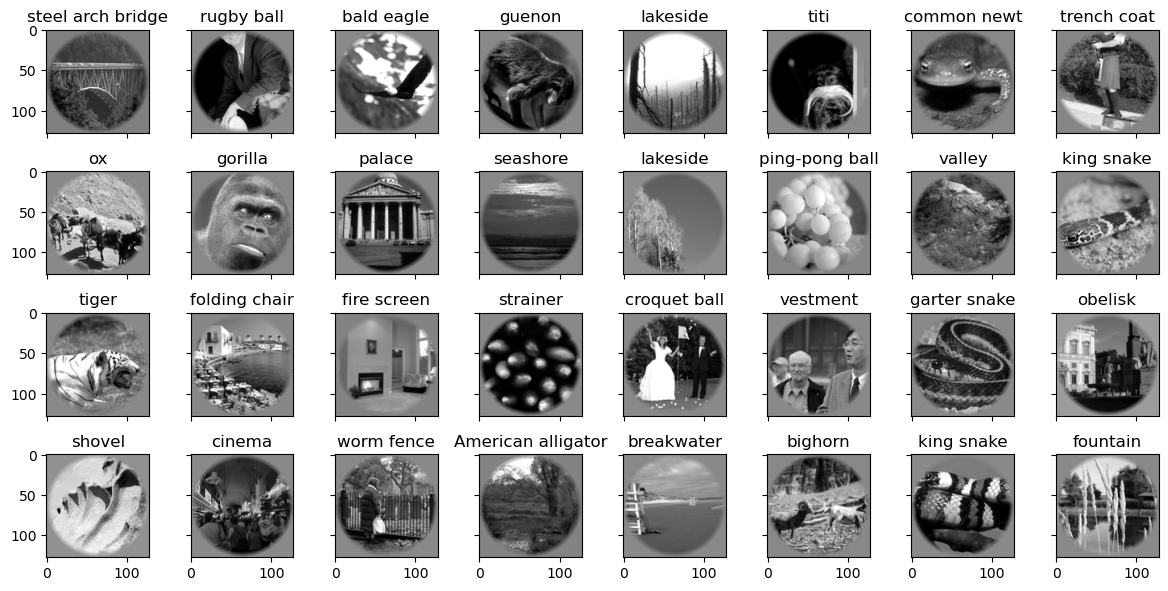

In [33]:
fig, axs = plt.subplots(4, 8, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli_test"], val_labels[-1, :]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
fig.tight_layout()
fig.show()

## Visualization

### Training data:

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

### Test data:

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

In [ ]:
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

### Other visualisations:

In [ ]:
# Sort dat['roi'] ascending and use this order to sort dat['responses']
roi_order = np.argsort(dat['roi'])
sorted_roi = dat['roi'][roi_order]
sorted_responses = dat['responses'][:, roi_order]

# Plot the sorted responses
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(sorted_responses,
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

In [ ]:
# Split dat['responses'] by their corresponding category in labels

# Get the unique categories in labels
categories = np.unique(labels[0, :])
print("Unique categories:", categories)

# Split the responses by category (each category should have shape (num_img, 8428))
responses_by_category = [dat['responses'][labels[0, :] == category, :] for category in categories]

# Print shapes of responses_by_category
for category, category_responses in zip(categories, responses_by_category):
  print(f"Category {category} has shape {category_responses.shape}")

In [ ]:
# Plot the responses for each category
for i in range(len(categories)):
    fig, ax = plt.subplots(figsize=(12, 2.5))
    ax.set_title(f"Category: {categories[i]}, # of images: {responses_by_category[i].shape[0]}")
    ax.set(xlabel="Voxel", ylabel="Stimulus")
    heatmap = ax.imshow(responses_by_category[i],
                        aspect="auto", vmin=-1, vmax=1, cmap="bwr")
    fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
    fig.tight_layout()
    fig.show()

### Visualization of the means for the ROIs, compared across different stimuli of the same category

In [ ]:
# Functions for plotting barplots of the different ROI's means for a specific category

def compute_roi_bins(image_index):
    responses = dat["responses"]
    rois = dat["roi"]
    roi_names_count = np.bincount(rois)[1:]

    roi_bins = [0, 0, 0, 0, 0, 0, 0]
    # For one image, go through all voxels recorded
    for i in range(len(responses[0])):
        roi_index = rois[i] - 1
        roi_bins[roi_index] += responses[image_index][i]
    for i in range(len(roi_bins)):
        roi_bins[i] /= roi_names_count[i]
    
    return roi_bins

def compute_roi_distributions_from_category(category, category_hierarchy, count):
    index = 0
    graphs_xvalues = []
    graphs_specific_labels = []
    while len(graphs_xvalues) < count:
        #print(labels[category_hierarchy][index], '/', category)
        if labels[category_hierarchy][index] == category: # category hierachy level
            graphs_xvalues.append(compute_roi_bins(index))
            graphs_specific_labels.append(labels[3][index])
        index += 1

    return graphs_xvalues, graphs_specific_labels

def barplot_roi_distribution(category, graph_xvalues, graph_specific_labels, ylim=[-0.4, 0.4], plot_rows=3, plot_cols=4):
    figure, axis = plt.subplots(plot_rows, plot_cols, figsize=(12,8))
    figure.suptitle(category)
    for ax, im, lbl in zip(axis.flat, graph_xvalues, graph_specific_labels):
        ax.set_ylim(ylim)
        ax.bar(range(len(im)), im)
        ax.set_title(lbl)
    figure.tight_layout()
    figure.show()

In [ ]:
# Plot barplots of ROI distribution for a specified category
# Specify category name, it's hierarchy level, and how many stimili there is
category_name = 'tree frog'
category_hierarchy = 3
count = 6
roi_distributions_values, roi_distibutions_labels = compute_roi_distributions_from_category(category_name, category_hierarchy, count)
barplot_roi_distribution(category_name, roi_distributions_values, roi_distibutions_labels)

C:\Users\mikke\AppData\Local\Temp\ipykernel_22348\119951743.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


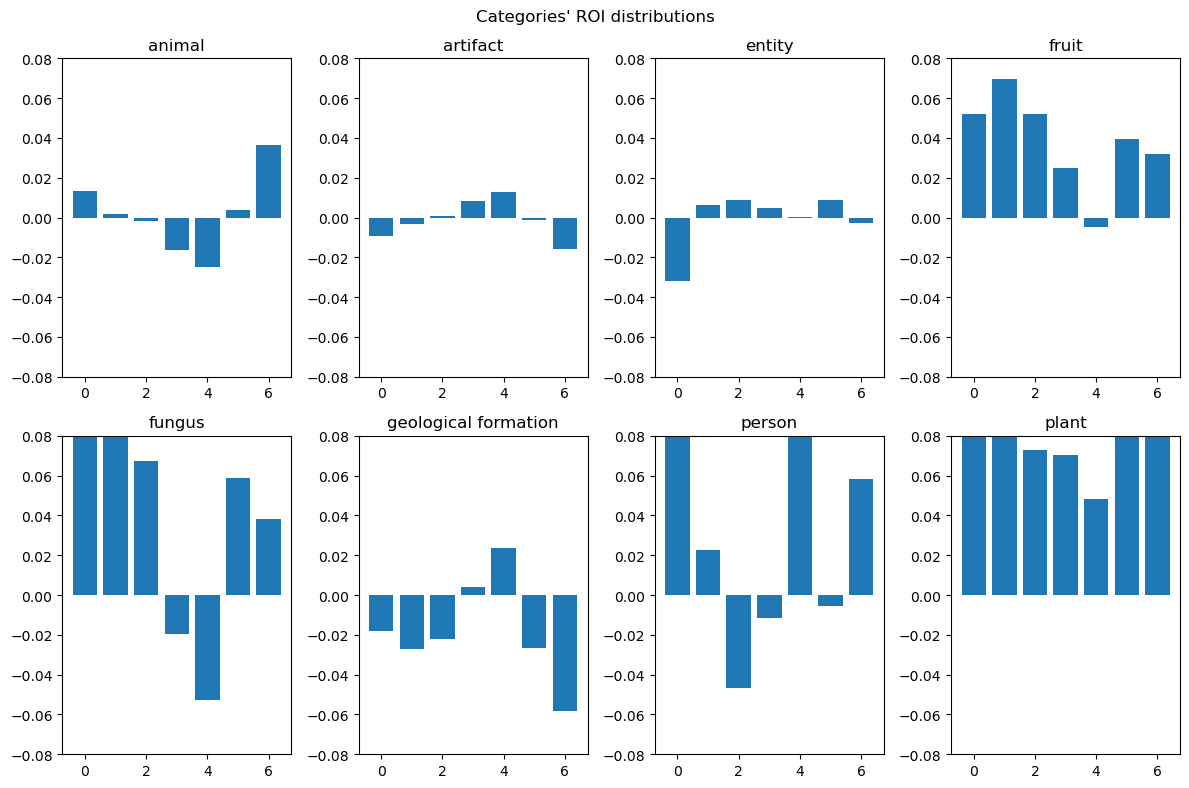

In [31]:
# Plot ROI distributions' means over all categories
# (Hardcoded to only work on category hierarchy 0 for now)

unique_labels = np.unique(labels[0, :])
# Lists to store values
total_roi_values = np.zeros((len(unique_labels), len(dat['roi_names']) - 1))
# (I didn't know how to get the sample count for each category?)
category_counts = [589, 812, 72, 77, 5, 192, 2, 1]

# Loop to go through each sample 
for i in range(len(labels[0])):
    # Loop to go through each unique label (category)
    for label in range(len(unique_labels)):
        # Assign computed ROI distribution to total ROI value list in correct index (hence the previous loop)
        if labels[0][i] == unique_labels[label]:
            total_roi_values[label] += compute_roi_bins(i)

# Loop to update total ROI value list to means
for label in range(len(total_roi_values)):
    total_roi_values[label] /= category_counts[label]

barplot_roi_distribution("Categories' ROI distributions", total_roi_values, unique_labels, ylim=[-0.08, 0.08], plot_rows=2, plot_cols=4)

## Preprocessing

### Removing categories with few samples

In [5]:
# Get indices for categories to remove (person, fungus, plant, instrumentality)
remove_indices_training = np.empty((0), dtype=int)
remove_indices_training = np.append(remove_indices_training, np.where(labels[0, :] == 'person')[0])
remove_indices_training = np.append(remove_indices_training, np.where(labels[0, :] == 'fungus')[0])
remove_indices_training = np.append(remove_indices_training,  np.where(labels[0, :] == 'plant')[0])
remove_indices_training = np.append(remove_indices_training, np.where(labels[1, :] == 'instrumentality')[0])
remove_indices_test = np.empty((0), dtype=int)
remove_indices_test = np.append(remove_indices_test, np.where(val_labels[0, :] == 'person')[0])
remove_indices_test = np.append(remove_indices_test, np.where(val_labels[0, :] == 'fungus')[0])
remove_indices_test = np.append(remove_indices_test,  np.where(val_labels[0, :] == 'plant')[0])
remove_indices_test = np.append(remove_indices_test, np.where(val_labels[1, :] == 'instrumentality')[0])

# Remove the data
# Training
training_inputs = np.delete(dat["stimuli"], remove_indices_training, axis=0)
training_outputs = np.delete(dat["responses"], remove_indices_training, axis=0)
training_labels = np.delete(labels, remove_indices_training, axis=1)
# Test
test_inputs = np.delete(dat["stimuli_test"], remove_indices_test, axis=0)
test_outputs = np.delete(dat["responses_test"], remove_indices_test, axis=0)
test_labels = np.delete(val_labels, remove_indices_test, axis=1)

print('Original training input size:', dat['stimuli'].shape)
print('Training input:', training_inputs.shape)
print('Training output:', training_outputs.shape)
print('Training labels:', training_labels.shape)
print('Original test input', dat['stimuli_test'].shape)
print('Test input:', test_inputs.shape)
print('Test output:', test_outputs.shape)
print('Test labels:', test_labels.shape)

Original training input size: (1750, 128, 128)
Training input: (1390, 128, 128)
Training output: (1390, 8428)
Training labels: (4, 1390)
Original test input (120, 128, 128)
Test input: (105, 128, 128)
Test output: (105, 8428)
Test labels: (4, 105)


### Reducing output size to number of ROI's instead of voxels

In [55]:
# Preprocess outputs to be the mean of each ROI instead of each voxel.
# This reduces the outputs to be predicted from 8428 to 7, hopefully not losing too much detail in the data in the process.
def reduce_outputs_to_ROIs(outputs):
    roi_count_dict = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))
    roi_order = np.argsort(dat['roi'])
    sorted_responses = training_outputs[:, roi_order]

    training_outputs_reduced_to_ROIs = np.zeros((len(outputs), 7))
    for sample in range(len(training_outputs_reduced_to_ROIs)):
        oldValue = 0
        count = 0
        for key, value in roi_count_dict.items():
            if value > 0:
                response_values = sorted_responses[:, oldValue:oldValue+value]
                summed_roi = np.mean(response_values[sample])
                training_outputs_reduced_to_ROIs[sample][count] = summed_roi
                count += 1
            oldValue = value
    return training_outputs_reduced_to_ROIs

print(reduce_outputs_to_ROIs(training_outputs).shape)
print('Example values:', reduce_outputs_to_ROIs(training_outputs)[0])

(1390, 7)
Example values: [-0.36620308 -0.36129435 -0.29608064 -0.34640159 -0.17965585 -0.37665786
 -0.32373576]


# Encoder model

In [7]:
# Variables
batch_size = 32
num_epochs = 100

In [23]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=8428):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        x = x.unsqueeze(1)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        #out = out.reshape(out.size(0), -1)
        
        out = self.avgpool(out)
        print("Here1")
        out = self.fc(out)
        print("Here2")
        out = self.fc1(out)
        print("Here3")
        out = self.fc2(out)
        return out

In [8]:
# CNN model for voxel-wise encoding
class EncoderModel(nn.Module):
    def __init__(self, dimension_length, num_outputs):
        super(EncoderModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=32, out_features=num_outputs)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension for grayscale images

        x = self.features(x)
        x = self.classifier(x)

        return x

In [9]:
class Encoder():
    def __init__(self, input, output):
        self.input = input
        self.output = output
        self.losses = []
        self.best_loss = 1000000
    
    # Method for setting up model and needed elements for it to be trained
    def setup_model(self, batch_size):
        # Seperate data
        x_train = self.input
        y_train = self.output

        # Create tensor from training data and labels
        x_train_tensor, y_train_tensor = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()
        training_data_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
        # Create dataloader from tensor
        train_dataloader = torch.utils.data.DataLoader(training_data_tensor, batch_size, shuffle=True)

        # Create encoder model
        #encoder_model = EncoderModel(x_train_tensor.shape[1], self.output.shape[1])
        encoder_model = AlexNet()
        
        # MSELoss instead of CrossEntropy beause it is more of a regression problem than classification
        criterion = nn.MSELoss()

        # Optimizer
        optimizer = optim.SGD(encoder_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-6, nesterov=True)

        return encoder_model, criterion, optimizer, train_dataloader

    # Method for training the model one epoch
    def train_one_epoch(self, train_dataloader, optimizer, criterion, encoder, epoch):
        train_running_loss = 0.0
        last_loss = 0.0

        # Put the model in training mode
        encoder = encoder.train()

        # Iterate through the data
        for i, data in enumerate(train_dataloader):
            inputs, labels = data

            outputs = encoder(inputs.float())
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()

            # Update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            last_loss = loss.detach().item()

            #if i % 100 == 0 and i != 0:
            #    print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch, i, train_running_loss / 100))
            #    train_running_loss = 0.0
            
        return last_loss


    # Method for training the model fully
    def train(self, batch_size, num_epochs):
        # Setup model
        encoder_model, criterion, optimizer, train_dataloader = self.setup_model(batch_size)
        
        # Training
        train_running_loss = 0.0
        for epoch in range(num_epochs):
            train_running_loss = self.train_one_epoch(train_dataloader, optimizer, criterion, encoder_model, epoch)
            self.losses.append(train_running_loss)

            if train_running_loss < self.best_loss:
                self.best_loss = train_running_loss
                best_model = encoder_model.state_dict()

            # Print loss value after each epoch
            print('Epoch: {} | Loss: {}'.format(epoch, train_running_loss))
        
            if (epoch+1) % 10 == 0:
                # Plot loss curve
                plt.figure(figsize=(10, 5))
                plt.title("Encoder Loss")
                plt.plot(self.losses, label="Encoder Loss")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.legend()
                # Save plot in png file if wanted
                #plt.savefig(f'loss_plotepoch{epoch+1}.png')
                plt.show()
        
        torch.save(best_model, os.path.join('./trained_models/', 'trainedmodel_best_epoch_{}.pth'.format(epoch)))

        return encoder_model

In [24]:
print('Original input data shape:', training_inputs.shape)
print('Original outputs data shape:', training_outputs.shape)

# Setup model and train it
encoder = Encoder(training_inputs, training_outputs)
trained_model = encoder.train(batch_size=batch_size, num_epochs=num_epochs)

Original input data shape: (1390, 128, 128)
Original outputs data shape: (1390, 8428)


ValueError: Input dimension should be at least 3

# Testing model

In [70]:
# Try model predicting data from a dataloader
def predicted_actual_classes(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for data, labels in dataloader:
            # Ensure data is on the same device as the model
            data = data.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Ensure labels are in the correct format
    # If your labels are one-hot encoded, convert them to class indices
    all_labels = [np.argmax(label) if isinstance(label, np.ndarray) else label for label in all_labels]

    return all_preds, all_labels

# Compute accuracy of model predictions based on predictions and actual labels
def compute_accuracy(predictions, actual):
    count = 0
    for i in range(len(predictions)):
        if predictions[i] == actual[i]:
            count += 1
    return count/len(predictions) * 100

# Plot a confusion matrix, visualising the model's predictions compared to the true labels
def plot_confusion_matrix(predictions, actual):
    cm = confusion_matrix(actual, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Try running trained model on test data
def test_trained_model(model, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    x_test = test_inputs
    y_test = test_outputs

    # Create tensor from training data and labels
    x_test_tensor, y_test_tensor = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float()
    test_data_tensor = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
    # Create dataloader from tensor
    test_dataloader = torch.utils.data.DataLoader(test_data_tensor, batch_size, shuffle=True)
    
     # Plot confusion matrix and get predicted/actual classes
    predicted_classes, actual_classes = predicted_actual_classes(model, test_dataloader)
    accuracy = compute_accuracy(predicted_classes, actual_classes)
    print(np.array(predicted_classes), np.array(actual_classes))
    print('Achieved accuracy:', "%.2f" % accuracy, '%')
    plot_confusion_matrix(predicted_classes, actual_classes)

(1390, 128, 128)
(1390, 7)
(105, 128, 128)
(105, 7)
[3 1 1 1 1 1 1 1 1 1 1 3 3 3 1 1 1 1 1 1 3 1 1 3 1 3 1 1 3 3 3 1 1 3 1 1 1
 1 1 1 1 1 1 1 1 3 1 1 3 1 1 1 1 1 1 3 1 3 3 1 1 3 3 3 1 1 3 1 1 3 1 1 1 1
 1 1 1 1 1 1 3 1 1 3 1 1 1 1 1 1 1 1 3 3 3 1 1 3 1 1 1 1 3 3 1] [  17  821 7882  196 1323 5095   53 7431   91  225 4146 2818 4374 1569
    8  909  128 3287   86 4663 2841 4663  399 6575 4663  376 6627   13
   81  922 4663 7304   48 4662 1314 4663 4400  909  340 5472 2004 2814
 7872   38   32 1475  909 4663 4043 4913  230 5501 6532  415 2494  223
   17 7768  229 6135 4663 4665  886   60   17 4663   62 5850 6575 3872
   11    9  801 5998   28   26 2483   13  132   32  481 4702 1323 7263
 6575  225   53   74 7431 4166 2621    7   91   17 3754 7943   33  478
  113 4663 2057   33 5117   14 4663]
Achieved accuracy: 0.00 %


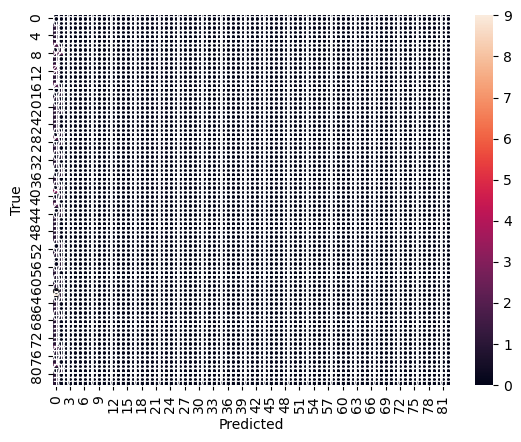

In [71]:
# Load model
print(training_inputs.shape)
print(reduce_outputs_to_ROIs(training_outputs).shape)
print(test_inputs.shape)
print(reduce_outputs_to_ROIs(test_outputs).shape)

model = EncoderModel(128, 7)

model.load_state_dict(torch.load('./trained_models/trainedmodel_98.pth'))

# Test model
test_trained_model(model=model, batch_size=batch_size)